# Data exploration, cleaning and manipulation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
albums = pd.read_csv('albums.csv', index_col=0)[1:]
albums['date'] = pd.to_datetime(albums['date'])
print(albums.shape)
albums.head(3)

(573946, 7)


,id,date,artist,album,rank,length,track_length
index,,,,,,,
1,2,2019-01-19,A Boogie Wit da Hoodie,Hoodie SZN,1.0,20.0,185233.800000
2,3,2019-01-19,21 Savage,I Am > I Was,2.0,15.0,211050.733333
3,4,2019-01-19,Soundtrack,Spider-Man: Into The Spider-Verse,3.0,13.0,190866.384615


In order to capture the essence of an album's popularity, we'll create a popularity score based on the number of weeks an album was in the top 200 and the rank it had each week. 

In [3]:
from sklearn.preprocessing import MinMaxScaler

def popularity_score(albums, log=False, sqrt=False):
    # Make rank 1 worth 200 points and rank 200 worth 1 point (per week) 
    albums['rank'] = np.abs(albums['rank'] - 201)
    # Aggregating the score per album 
    popularity = albums.groupby(['album', 'artist'])['rank'].sum()
    # Normalize potentially skewed score distribution with log or square root  
    if log:
        popularity = np.log(popularity)
    if sqrt:
        popularity = np.sqrt(popularity)
    # Scale popularity score to 0-10 for easier interpretability 
    scaler = MinMaxScaler(feature_range=(0,10)) 
    popularity = pd.DataFrame(scaler.fit_transform(popularity.values.reshape(-1,1)), index=popularity.index, columns=['popularity_score'])
    return popularity

For the future regression coefficients to be interpretable, the score should be distributed somewhat normally. Let's see which normalizing function leads to the best results!

Text(0, 0.5, 'frequency')

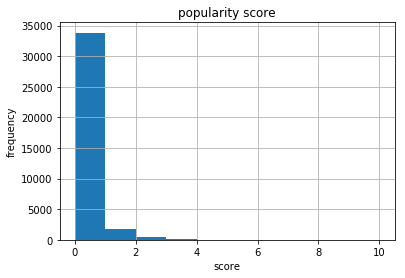

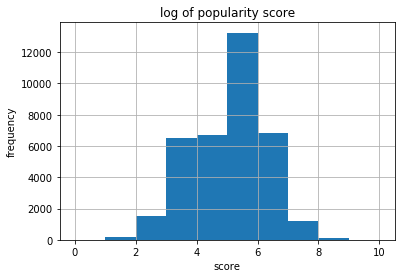

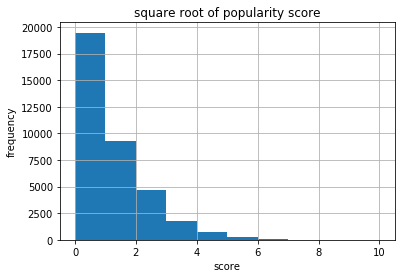

In [4]:
popularity_score(albums).hist()
plt.title('popularity score')
plt.xlabel('score')
plt.ylabel('frequency')
popularity_score(albums, log=True).hist()
plt.title('log of popularity score')
plt.xlabel('score')
plt.ylabel('frequency')
popularity_score(albums, sqrt=True).hist()
plt.title('square root of popularity score')
plt.xlabel('score')
plt.ylabel('frequency')

The histograms show that the log of popularity score is the closest to a normal distribution, so we'll take the log of our popularity score for our regression.

In [5]:
popularity = popularity_score(albums, log=True)
popularity.sort_values(by='popularity_score', ascending=False).head(10)

,,popularity_score
album,artist,
The Dark Side Of The Moon,Pink Floyd,10.000000
Legend: The Best Of...,Bob Marley And The Wailers,9.246509
Journey's Greatest Hits,Journey,9.243439
Chronicle The 20 Greatest Hits,Creedence Clearwater Revival Featuring John Fogerty,9.135017
Nevermind,Nirvana,9.108570
Greatest Hits,Guns N' Roses,9.093810
Curtain Call: The Hits,Eminem,9.057646
Metallica,Metallica,9.054467
Back In Black,AC/DC,8.946512


In [6]:
acoustic_features = pd.read_csv('acoustic_features.csv', index_col=0)
print(acoustic_features.shape)
acoustic_features.head(3)

(339855, 19)


,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
index,,,,,,,,,,,,,,,,,,,
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


Cleaning acoustic features

In [7]:
# Remove tracks less than a minute long 
features = acoustic_features.loc[acoustic_features['duration_ms'] > 60000]
# Drop non numeric columns 
features.drop(columns=['id', 'song', 'album_id', 'date'], inplace=True)
# Extract total run time per album 
length = features.groupby(['album', 'artist'])['duration_ms'].sum()
# Set index to album  
features.set_index(['album', 'artist'], inplace=True)
# Set length name to weights for clarity in weighted mean calculation
length.name = 'weights'
features.head(3)

C:\Users\shaiyon\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


acousticness  danceability  duration_ms  \
album      artist                                                            
Hoodie SZN A Boogie Wit da Hoodie        0.0555         0.754     142301.0   
           A Boogie Wit da Hoodie        0.2920         0.860     152829.0   
           A Boogie Wit da Hoodie        0.1530         0.718     215305.0   

                                   energy  instrumentalness  key  liveness  \
album      artist                                                            
Hoodie SZN A Boogie Wit da Hoodie   0.663          0.000000  6.0     0.101   
           A Boogie Wit da Hoodie   0.418          0.000000  7.0     0.106   
           A Boogie Wit da Hoodie   0.454          0.000046  8.0     0.116   

                                   loudness  mode  speechiness    tempo  \
album      artist                                                         
Hoodie SZN A Boogie Wit da Hoodie    -6.311   0.0        0.427   90.195   
           A Boogie Wit da Hoodie    -9.061   0.0        0.158  126.023   
           A Boogie Wit da Hoodie    -9.012   1.0        0.127   89.483   

                                   time_signature  valence  
album      artist                                           
Hoodie SZN A Boogie Wit da Hoodie             4.0    0.207  
           A Boogie Wit da Hoodie             4.0    0.374  
           A Boogie Wit da Hoodie             4.0    0.196

Aggregating songs by album weighted by the percentage of the album they take up. 

In [8]:
features = features.join(length)
# Extract percentage of the album each song takes up 
features['weights'] = features['duration_ms'] / features['weights']
# Multiply weights by each column 
features = features.drop(['weights', 'duration_ms'], axis=1).mul(features['weights'], axis=0)
length.name = 'length'
# Sum up the weighted data, grouping by album. Then add album length. 
features = features.groupby(['album', 'artist']).sum().join(length)
features.head(3)

,,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,length
album,artist,,,,,,,,,,,,,
!!Going Places!!,Herb Alpert & The Tijuana Brass,0.504944,0.634360,0.497121,0.636872,5.469885,0.107299,-11.909669,0.578203,0.093018,115.741766,4.000000,0.636955,1786385.0
!Viva El Amor!,Pretenders,0.102661,0.507975,0.717777,0.002417,7.703102,0.165748,-5.041795,0.723996,0.037021,129.670102,3.850478,0.530391,2715761.0
!Viva La Cobra!,Cobra Starship,0.046689,0.586020,0.789629,0.000007,2.522854,0.242735,-5.825477,0.282722,0.071973,122.389089,3.701332,0.700530,2219053.0


Next, we'll center and scale the features to have a mean of 0 and unit variance to make future regression coefficients significantly more interpretable.

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features = pd.DataFrame(ss.fit_transform(features), columns=features.columns, index=features.index)
features.head(3)

,,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,length
album,artist,,,,,,,,,,,,,
!!Going Places!!,Herb Alpert & The Tijuana Brass,0.906995,0.729465,-0.658618,2.933496,0.181743,-0.785637,-0.758761,-0.608828,0.096166,-0.374514,0.610703,0.802187,-0.830192
!Viva El Amor!,Pretenders,-0.746051,-0.261481,0.529187,-0.516598,1.935347,-0.381715,1.029967,0.092515,-0.497468,0.714096,-0.303436,0.170338,-0.248708
!Viva La Cobra!,Cobra Starship,-0.976051,0.350445,0.915969,-0.529705,-2.132375,0.150313,0.825858,-2.030254,-0.126942,0.145027,-1.215272,1.179136,-0.559484


In [10]:
reviews = pd.read_csv('reviews.csv').drop(['index','id','role'], axis=1)
reviews.set_index(['album', 'artist'], inplace=True)
reviews.rename(columns={'score':'review_score'}, inplace=True)
print(reviews.shape)
reviews.head(3)

(20873, 7)


,,genre,review_score,date,author,review,bnm,link
album,artist,,,,,,,
“…The Best Live Show of All Time” — NME EP,David Byrne,Rock,5.5,January 11 2019,Andy Beta,"Viva Brother, Terris, Mansun, the Twang, Joe L...",0,https://pitchfork.com/reviews/albums/david-byr...
Lost Lovesongs / Lostsongs Vol. 2,DJ Healer,Electronic,6.2,January 11 2019,Chal Ravens,"The Prince of Denmark—that is, the proper prin...",0,https://pitchfork.com/reviews/albums/dj-healer...
Roman Birds,Jorge Velez,Electronic,7.9,January 10 2019,Philip Sherburne,"Jorge Velez has long been prolific, but that’s...",0,https://pitchfork.com/reviews/albums/jorge-vel...


In [11]:
print(reviews['genre'].nunique())
reviews['genre'].unique()[0:30]

137


array(['Rock', 'Electronic', 'Rap', 'Experimental', 'Pop/R&B',
       'Folk/Country', nan, 'Metal', 'Rock,Pop/R&B', 'Jazz',
       'Rock,Experimental', 'Metal,Rock', 'Jazz,Experimental',
       'Experimental,Electronic', 'Folk/Country,Experimental',
       'Experimental,Rock', 'Global', 'Pop/R&B,Electronic', 'Rap,Pop/R&B',
       'Electronic,Rock', 'Pop/R&B,Rap', 'Pop/R&B,Folk/Country',
       'Electronic,Metal', 'Electronic,Pop/R&B',
       'Electronic,Experimental', 'Pop/R&B,Rock',
       'Electronic,Experimental,Folk/Country', 'Pop/R&B,Global',
       'Rock,Folk/Country', 'Pop/R&B,Experimental'], dtype=object)

We want to regress the data separately for each genre, but 137 is simply too many genres to deal with. So we'll use a regular expression to simplify the strings in the genre column to be only the first/primary genre. This puts the albums into broader, more easily digestable categories.

In [12]:
reviews['genre'] = reviews['genre'].replace(r'(,|/)[\w\W]+', '', regex=True)
print(reviews['genre'].nunique())
reviews['genre'].unique()

9


array(['Rock', 'Electronic', 'Rap', 'Experimental', 'Pop', 'Folk', nan,
       'Metal', 'Jazz', 'Global'], dtype=object)

Now that the data is fully cleaned, it's time to join the features and scores, removing albums that don't have data in the process.

In [16]:
data = features.reset_index().join(reviews[['genre', 'review_score']], on=['album', 'artist']).set_index(['album', 'artist']).dropna()
data = data.reset_index().join(popularity, on=['album', 'artist']).set_index(['album', 'artist']).fillna(0)
print(data.shape)
data.head(3)

(1761, 16)


,,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,length,genre,review_score,popularity_score
album,artist,,,,,,,,,,,,,,,,
$O$,Die Antwoord,-0.714888,1.609190,0.489080,-0.140446,-0.457791,-0.280548,0.535534,-0.761014,1.537186,0.315966,1.459717,0.166186,0.076382,Rap,5.5,3.173876
...And Star Power,Foxygen,-0.334712,-1.440631,-0.054928,0.947206,-0.083812,0.425895,0.125685,1.017485,-0.230305,0.318942,-0.377202,-0.271276,1.122319,Rock,7.0,2.912184
...And Then You Shoot Your Cousin,The Roots,0.547939,0.574016,-0.510038,-0.350169,-0.335559,-0.667088,-0.686169,-1.928120,0.923312,-0.959039,0.610703,-0.789071,-0.718414,Rap,7.2,3.617485


# Linear Regression on acoustic features and review score


Rap
R squared: 0.8928646991421793
Sample size: 363

acousticness       -1.416767
danceability        1.549949
energy             -0.275459
instrumentalness    0.152798
key                -0.165401
liveness            0.581662
loudness            1.143432
mode               -0.800480
speechiness         1.890992
tempo               0.018413
time_signature     -0.427440
valence            -1.113954
length              0.092944
dtype: float64

Rock
R squared: 0.6849009380754791
Sample size: 786

acousticness         0.923268
danceability        -2.016985
energy               0.618247
instrumentalness     0.608723
key                 -0.222588
liveness            -0.832521
loudness             0.829520
mode                 0.187653
speechiness        -10.092863
tempo                0.581945
time_signature      -0.126048
valence              0.162000
length               0.478085
dtype: float64

Metal
R squared: 0.9132169458880873
Sample size: 76

acousticness       -5.026408
danceability 

Text(0, 0.5, 'Residuals')

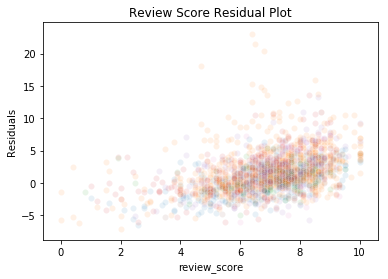

In [14]:
import statsmodels.api as sm

for genre in data['genre'].unique():
    genre_df = data.loc[data['genre'] == genre]
    X = genre_df.iloc[:,:13]
    y = genre_df['review_score']
    # Ignore genres with less observations than features 
    if len(X) > len(X.columns):
        ols = sm.OLS(y, X)
        res = ols.fit()
        print('\n' + format(genre))
        print('R squared: ' + format(res.rsquared))
        print('Sample size: ' + format(len(X))  + '\n')
        # Regression Coefficients 
        print(res.params)
        # Plot the residuals 
        sns.scatterplot(x=y, y=res.resid, alpha=0.1)
plt.title('Review Score Residual Plot')
plt.ylabel('Residuals')

# Linear Regression on acoustic features and popularity score


Rap
R squared: 0.8722599747963979
Sample size: 363

acousticness       -1.102572
danceability        1.005723
energy             -0.150361
instrumentalness   -0.029756
key                 0.002162
liveness            0.088313
loudness            1.149414
mode               -0.553274
speechiness         1.205517
tempo               0.180523
time_signature     -0.274341
valence            -1.012721
length              0.843920
dtype: float64

Rock
R squared: 0.6315239287763417
Sample size: 786

acousticness        0.273367
danceability       -1.016836
energy              0.233323
instrumentalness    0.028507
key                -0.081470
liveness           -0.506802
loudness            0.573791
mode                0.067761
speechiness        -6.748665
tempo               0.470988
time_signature     -0.009573
valence            -0.074008
length              0.519743
dtype: float64

Metal
R squared: 0.7821248227746967
Sample size: 76

acousticness       -3.992530
danceability       -0.5146

Text(0, 0.5, 'Residuals')

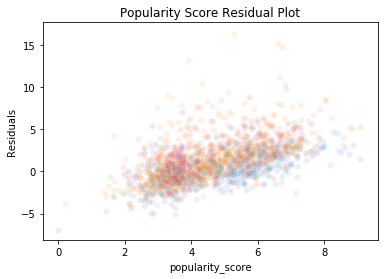

In [15]:
for genre in data['genre'].unique():
    genre_df = data.loc[data['genre'] == genre]
    X = genre_df.iloc[:,:13]
    y = genre_df['popularity_score']
    # Ignore genres with less observations than features 
    if len(X) > len(X.columns):
        ols = sm.OLS(y, X)
        res = ols.fit()
        print('\n' + format(genre))
        print('R squared: ' + format(res.rsquared))
        print('Sample size: ' + format(len(X))  + '\n')
        # Regression Coefficients 
        print(res.params)
        # Plot the residuals 
        sns.scatterplot(x=y, y=res.resid, alpha=0.1)
plt.title('Popularity Score Residual Plot')
plt.ylabel('Residuals')

Both of the residual plots have a slight positive trend, indicating a slight change in variance, but it appears to be small enough to ignore for now.